**10 Animals CLassification-VGG16_Transfer_learing**
*   Pre-train Model: VGG16
*   Dataset: Animals-10 (source:https://www.kaggle.com/datasets/alessiocorrado99/animals10)
*   kind Of animal: ['dog', 'horse','elephant','butterfly','chicken','cat','cow','sheep','squirrel','spider']


# Import lib

In [ ]:
#pre-process
from google.colab import files
import os
import random
from shutil import copytree, copy
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import load_img, img_to_array

#training model
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten , Conv2D, MaxPool2D
from keras.optimizers import RMSprop

#callback
from keras.callbacks import EarlyStopping , ModelCheckpoint, ReduceLROnPlateau

# Dowload Raw Dataset from Kaggle

In [ ]:
#----------------------------upload kaggle.json (API key)--------------------------------
!pip install -q kaggle

#upload kaggle api key file
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#----------------------------Dowload dataset--------------------------------
!kaggle datasets download -d alessiocorrado99/animals10
!unzip -q animals10.zip

rm: cannot remove '/root/.kaggle': No such file or directory
100% 584M/586M [00:21<00:00, 32.9MB/s]
100% 586M/586M [00:21<00:00, 29.1MB/s]


# Helper Function

In [ ]:
def plot_bar_chart(classes_name, class_distribution):
  plt.figure(figsize = (9, 4))
  plt.bar(classes_name, class_distribution,
          width = 0.6,)

  plt.axhline(np.mean(class_distribution), color='k', linestyle='--', label="Mean Images = {}".format(np.mean(class_distribution)))

  plt.title("Class Distribution")
  plt.legend()
  plt.show()

  print(f"\nClass Distribution: {class_distribution}\nTotal Image: {sum(class_distribution)}")

In [ ]:
def augmentation_image(FILE_IMG, name):
    datagen = ImageDataGenerator(
            rotation_range=0.05,    #Randomly rotate images in the range
            zoom_range = 0.2,       #Randomly zoom image
            width_shift_range=0.1,  #Randomly shift images horizontally
            height_shift_range=0.1, #Randomly shift images vertically
            shear_range=0.05        #Randomly shear images
    )

    img = load_img(FILE_IMG)
    img = np.array(img)  # this is a Numpy array with shape (150, 150, 3)
    img = img.reshape((1,) + img.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

    dst_dir = f"/content/augment_image/{name}" #desired destination folder

    augmented_data = datagen.flow(
      img,
      batch_size=32,
      save_to_dir=dst_dir,
      save_prefix='aug',
      save_format='jpeg'
    )

    i = 0
    for batch in augmented_data:

      next(augmented_data)[0].astype('uint8')

      i += 1
      if i == 256/32:  # Set the condition based on the total number of augmented images you want (1536/32=48images)
          break  # Break the loop to avoid infinite iterations

# Pre-processing Dataset

## Visualize Raw Data

In [ ]:
# Translate italy(it) into english(en)
classes = {
    'cane': 'dog',
    'cavallo': 'horse',
    'elefante': 'elephant',
    'farfalla': 'butterfly',
    'gallina': 'chicken',
    'gatto': 'cat',
    'mucca': 'cow',
    'pecora': 'sheep',
    'scoiattolo': 'squirrel',
    'ragno': 'spider'
}

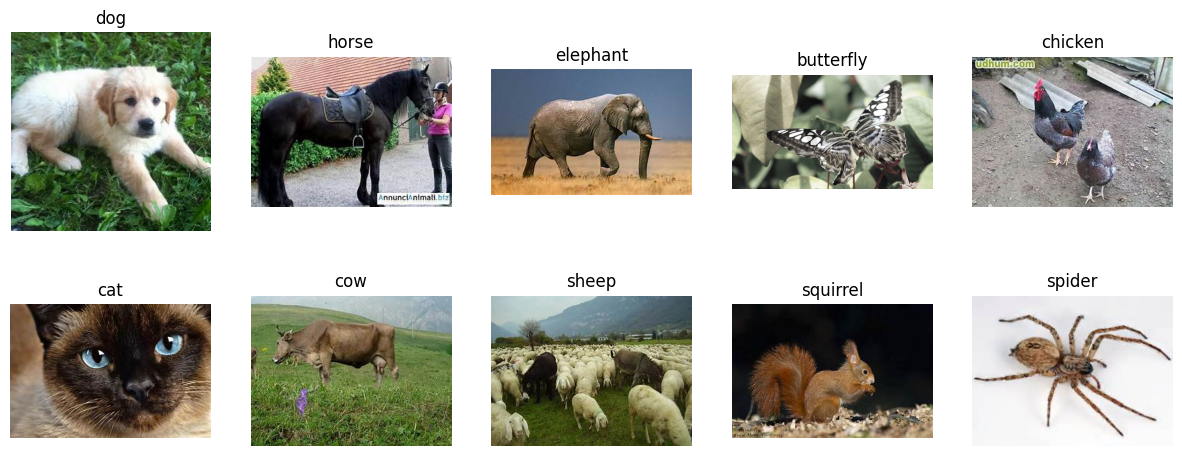

In [ ]:
# show some raw image
plt.figure(figsize=(15, 15))

for i, name in enumerate(classes.items()): # name = ('cane', 'dog')

  random_file = random.choice(os.listdir(f"/content/raw-img/{name[0]}"))

  # image = cv2.imread(f"/content/raw-img/{name[0]}/{random_file}")
  # image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
  image = load_img(f"/content/raw-img/{name[0]}/{random_file}")

  plt.subplot(5, 5, i+1)
  plt.imshow(image)
  plt.title(f"{name[1]}")
  plt.axis("off")

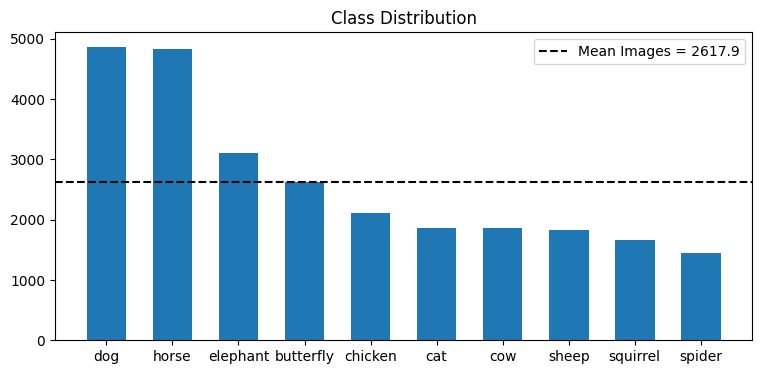


Class Distribution: [4863, 4821, 3098, 2623, 2112, 1866, 1862, 1820, 1668, 1446]
Total Image: 26179


In [ ]:
class_dis = [len(os.listdir('/content/raw-img/{}'.format(name_it))) for name_it, name_en in classes.items()]
class_dis = sorted(class_dis)[::-1]
classes_name = [name_en for name_it, name_en in classes.items()]

# plot class distribution
plot_bar_chart(classes_name, class_dis)

*As the chart show, number of each animal image is not same quality. It means the model would be biased. have to apply data augmentation and make all class are equal*

## Augmentation

### *Example*

In [ ]:
# # random image for an example
# path = "/content/raw-img/cane/" + random.choice(os.listdir("/content/raw-img/cane/"))

# #image augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
# )

# img = load_img(path)
# img = np.array(img)  # this is a Numpy array with shape (150, 150, 3)
# img = img.reshape((1,) + img.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# save_dir = "/content/preview"
# os.makedirs(save_dir, exist_ok=True)

# augmented_data = datagen.flow(
#     img,
#     batch_size=32,
#     # save_to_dir=save_dir,
#     # save_prefix='aug',
#     # save_format='jpeg'
# )
# plt.figure(figsize=(18,18))
# # Generate augmented images and display them
# i = 0
# for batch in augmented_data:

#     image = next(augmented_data)[0].astype('uint8')

#     plt.subplot(4, 4, i + 1)
#     plt.imshow(image)
#     plt.axis("off")

#     i += 1
#     if i == 128 / 32:  # Set the condition based on the total number of augmented images you want
#         break  # Break the loop to avoid infinite iterations

# plt.show()

### *Making Augmentation*

In [ ]:
# creat folder for augmented image
os.makedirs("/content/augment_image/", exist_ok=True)

# peak number of image of 10 classes
peak = max(class_dis)

for name_it, name_en in classes.items():
  # creat folder for augmented image each animal
  os.makedirs(f"/content/augment_image/{name_it}", exist_ok=True)

  n_each_class = len(os.listdir(f'/content/raw-img/{name_it}')) + len(os.listdir(f'/content/augment_image/{name_it}'))
  while peak > n_each_class:

    # random image for an example
    FILE_IMG = f"/content/raw-img/{name_it}/" + random.choice(os.listdir(f"/content/raw-img/{name_it}/"))
    augmentation_image(FILE_IMG, name_it)

    n_each_class = len(os.listdir(f'/content/raw-img/{name_it}')) + len(os.listdir(f'/content/augment_image/{name_it}'))


### *Merge two folders into dataset-img folder*

In [ ]:
for name_it, name_en in classes.items():
  dst = f'/content/augment_image/{name_it}'
  src = f'/content/raw-img/{name_it}'
  copytree(src, dst, dirs_exist_ok=True)

## Distribution after making image augmentation

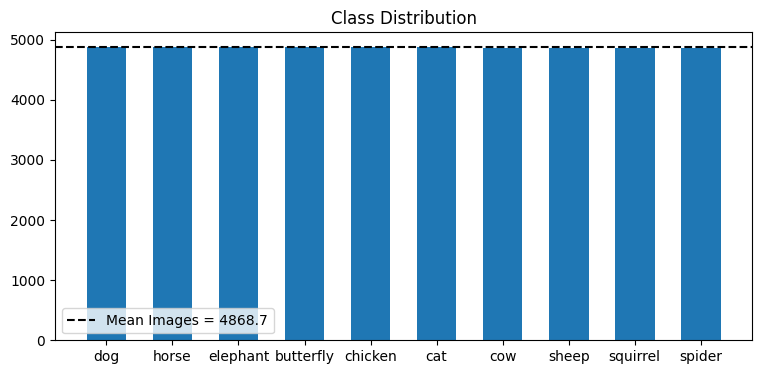


Class Distribution: [4877, 4873, 4872, 4870, 4869, 4868, 4867, 4864, 4864, 4863]
Total Image: 48687


In [ ]:
class_dis_aug = [len(os.listdir(f'/content/augment_image/{name_it}')) for name_it, name_en in classes.items()]
class_dis_aug = sorted(class_dis_aug)[::-1]
classes_name = [name_en for name_it, name_en in classes.items()]

# plot class distribution
plot_bar_chart(classes_name, class_dis_aug)

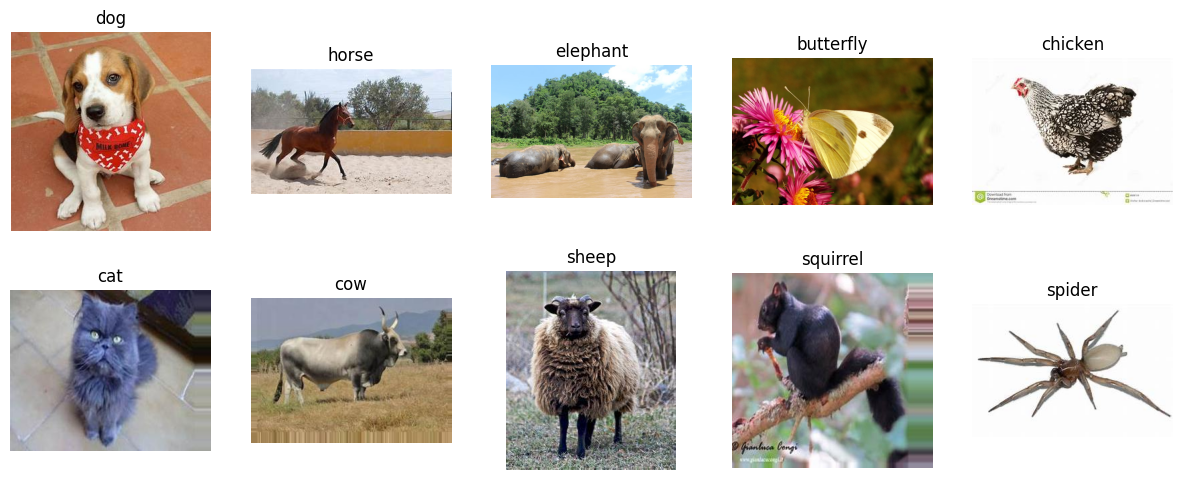

In [ ]:
# show some augmented image
plt.figure(figsize=(15, 15))

for i, name in enumerate(classes.items()): # name = ('cane', 'dog')

  try:
    random_file = random.choice(os.listdir(f"/content/augment_image/{name[0]}"))

    # image = cv2.imread(f"/content/raw-img/{name[0]}/{random_file}")
    # image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
    image = load_img(f"/content/augment_image/{name[0]}/{random_file}")

    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title(f"{name[1]}")
    plt.axis("off")
  except:
    print('error')

## Split Image into Train, Valid and Test 80:10:10

In [ ]:
# create directory for train, validation and test datasets
main_dir = '/content/dataset-img'
sub_dir = ['train', 'valid', 'test']

for subdir in sub_dir:
  for label_it, label_en in classes.items():
    newdir = "{}/{}/{}".format(main_dir, subdir, label_en)
    os.makedirs(newdir, exist_ok=True)

In [ ]:
# split image dataset into train, validation and test datasets
for label_it, label_en in classes.items():

  # source folder, /raw-img
  src = '/content/augment_image/{}/'.format(label_it)

  # each animals image collection
  chunk_animal_img = glob.glob(src + "*")

  # shuffle images of each animal
  random.shuffle(chunk_animal_img)

  len_each_animal = len(chunk_animal_img)
  train_size = int(len_each_animal * 0.8) # train 80%
  val_size = int(len_each_animal * 0.1)  # valid 10%
  test_size = int(len_each_animal * 0.1) # test 10%

  for i, path in enumerate(chunk_animal_img):
    if i < train_size:
      dst = '/content/dataset-img/train/{}'.format(label_en)
    elif i < train_size + val_size:
      dst = '/content/dataset-img/valid/{}'.format(label_en)
    else:
      dst = '/content/dataset-img/test/{}'.format(label_en)

    # copy file into destination => /content/dataset-img/train/{label_en}
    copy(path, dst)

In [ ]:
# # dowload dataset-img
!zip -r /content/dataset-img.zip /content/dataset-img


In [ ]:
# from google.colab import files
# files.download('/content/dataset-img.zip')

## Transform Data for Training

In [ ]:
train_data_dir = "/content/dataset-img/train/"
valid_data_dir = "/content/dataset-img/valid/"
test_data_dir = "/content/dataset-img/test/"

width_img, height_img = 256, 256
batch_size = 32

In [ ]:
# 10 classes
class_names = [name_en for name_it, name_en in classes.items()]
class_names

['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'squirrel',
 'spider']

In [ ]:
#prepare training dataset
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    train_data_dir,
    target_size=(width_img, height_img),
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size,
    classes = class_names
)

valid_data = datagen.flow_from_directory(
    valid_data_dir,
    target_size=(width_img, height_img),
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size,
    classes = class_names
)

test_data = datagen.flow_from_directory(
    test_data_dir,
    target_size=(width_img, height_img),
    class_mode='categorical',
    shuffle=True,
    batch_size=batch_size,
    classes = class_names
)
train_data.class_indices

Found 38946 images belonging to 10 classes.
Found 4864 images belonging to 10 classes.
Found 4877 images belonging to 10 classes.


{'dog': 0,
 'horse': 1,
 'elephant': 2,
 'butterfly': 3,
 'chicken': 4,
 'cat': 5,
 'cow': 6,
 'sheep': 7,
 'squirrel': 8,
 'spider': 9}

In [ ]:
#2D one-hot encoded
for i in range(10):
  image_batch, label_batch = next(train_data)
  print(label_batch[0], f"=> {class_names[np.argmax(label_batch)]}")

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] => squirrel
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] => chicken
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] => sheep
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] => sheep
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] => squirrel
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] => sheep
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] => spider
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] => butterfly
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] => cow
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] => chicken


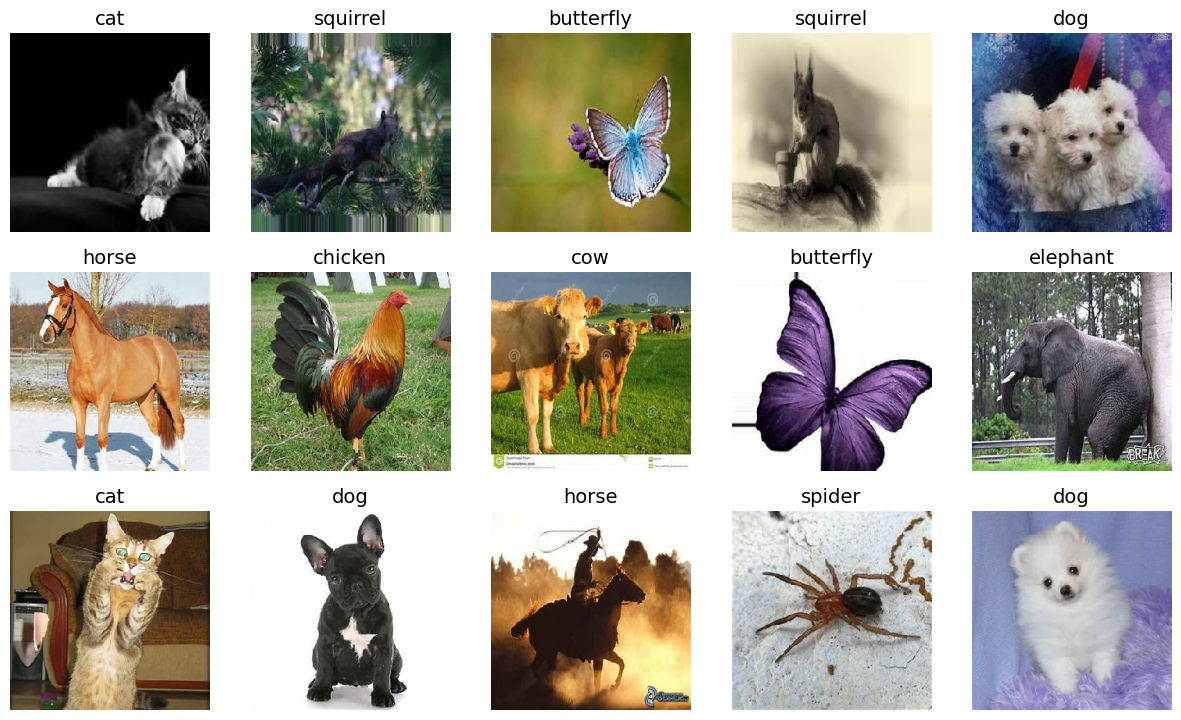

In [ ]:
# #vizualise the images from datagenerator
def show_batch(image_batch, label_batch):
  fig = plt.figure(figsize=(15,15))
  fig.patch.set_facecolor('white')
  for n in range(15):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(f'{class_names[np.argmax(label_batch[n])]}', fontsize=14)
      plt.axis('off')

image_batch, label_batch = next(train_data)
show_batch(image_batch, label_batch)

# Model defination

## Fine-tuning with VGG16

In [ ]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(width_img, height_img, 3),
)

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a fully connected layer on top of the base model
model = Sequential()
model.add(base_model)
model.add(Flatten(input_shape= base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               8388864   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 10)                2570      
                                                                 
Total params: 23106122 (88.14 MB)
Trainable params: 8391434 (32.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data,
    callbacks = early_stopping
)

Epoch 1/20
1218/1218 [==============================] - 143s 116ms/step - loss: 0.6819 - accuracy: 0.7743 - val_loss: 0.4016 - val_accuracy: 0.8690
Epoch 2/20
1218/1218 [==============================] - 140s 115ms/step - loss: 0.3080 - accuracy: 0.9020 - val_loss: 0.3005 - val_accuracy: 0.9069
Epoch 3/20
1218/1218 [==============================] - 146s 120ms/step - loss: 0.2088 - accuracy: 0.9347 - val_loss: 0.3432 - val_accuracy: 0.8995
Epoch 4/20
1218/1218 [==============================] - 147s 121ms/step - loss: 0.1532 - accuracy: 0.9523 - val_loss: 0.2720 - val_accuracy: 0.9186
Epoch 5/20
1218/1218 [==============================] - 147s 120ms/step - loss: 0.1149 - accuracy: 0.9635 - val_loss: 0.2429 - val_accuracy: 0.9328
Epoch 6/20
1218/1218 [==============================] - 131s 107ms/step - loss: 0.0863 - accuracy: 0.9729 - val_loss: 0.2721 - val_accuracy: 0.9295
Epoch 7/20
1218/1218 [==============================] - 124s 102ms/step - loss: 0.0700 - accuracy: 0.9777 - val_

In [ ]:
model.save('Animal-10-VGG16-transfer_learing.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!zip /content/Animal-10-VGG16-transfer_learing.h5.zip /content/Animal-10-VGG16-transfer_learing.h5

  adding: content/Animal-10-VGG16-transfer_learing.h5 (deflated 14%)


In [ ]:
files.download('/content/Animal-10-VGG16-transfer_learing.h5.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation

### Graphing our training

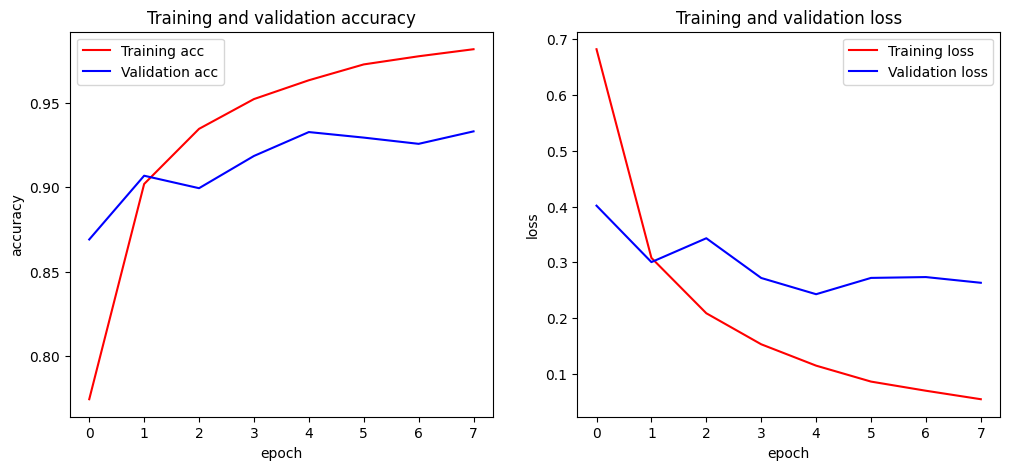

In [ ]:
#Graphing our training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

### Validation

In [ ]:
# evaluate with validation dataset
valid_loss, valid_acc = model.evaluate(valid_data)

152/152 [==============================] - 15s 100ms/step - loss: 0.2429 - accuracy: 0.9328


### Test

In [ ]:
# evaluate with test dataset
test_loss, test_acc = model.evaluate(test_data)

153/153 [==============================] - 19s 126ms/step - loss: 0.2419 - accuracy: 0.9307


# Prediction

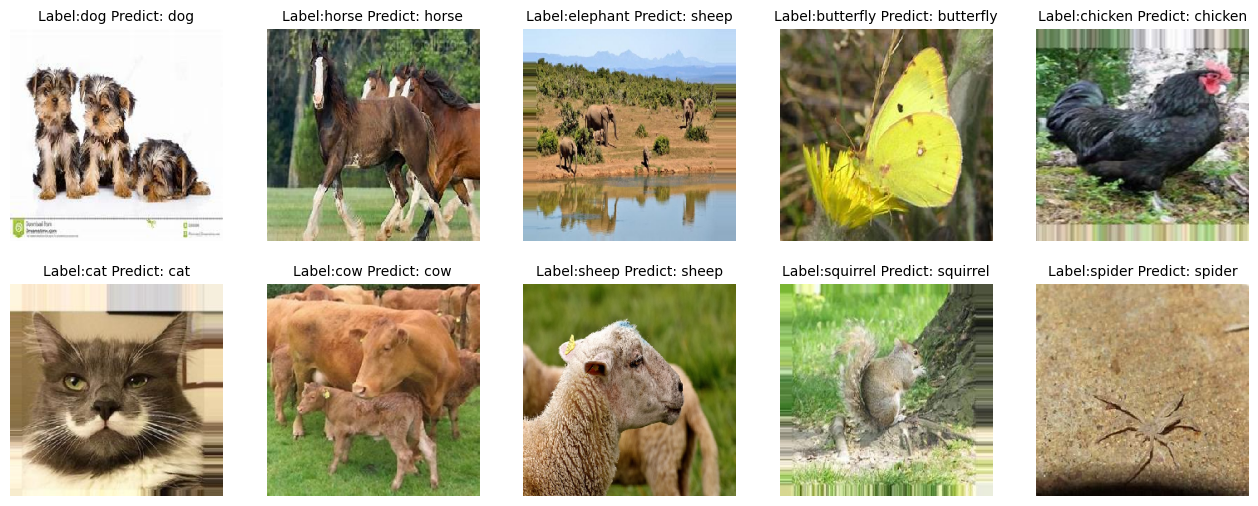

In [ ]:
fig = plt.figure(figsize=(16,16))
for i, name in enumerate(class_names):

  path_file = random.choice(os.listdir(f"/content/dataset-img/test/{name}"))
  img = load_img(f"/content/dataset-img/test/{name}/{path_file}", target_size=(256,256))

  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  #Prediction
  pred_cls = model.predict(images, batch_size=32, verbose=None)

  ax = plt.subplot(5,5,i+1)
  plt.imshow(img)
  plt.title(f"Label:{name} Predict: {class_names[np.argmax(pred_cls)]}", fontsize=10)
  plt.axis('off')

plt.show()

In [ ]:
#using model
from keras.models import load_model

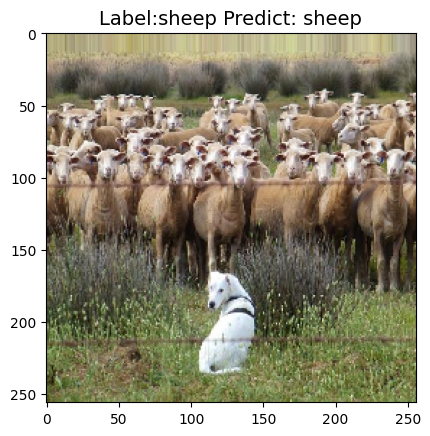

In [ ]:
animal = "sheep"
fined_tune_model = load_model('/content/Animal-10-VGG16-transfer_learing.h5')

#dog image
path = random.choice(os.listdir(f"/content/dataset-img/test/{animal}"))
img = load_img(f"/content/dataset-img/test/{animal}/{path}", target_size=(256,256))

x = img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
#Prediction
pred_cls = fined_tune_model.predict(images, batch_size=32, verbose=None)
plt.title(f"Label:{animal} Predict: {class_names[np.argmax(pred_cls)]}", fontsize=14)
plt.imshow(img)
plt.show()